## **모델 성능 비교**

1. RandomForest ✅

*   RMSE: 0.1498
*   R² Score: 0.6413

2. XGBoost

*   RMSE: 0.1550
*   R² Score: 0.6157

3. LightGBM

*   RMSE: 0.1604
*   R² Score: 0.5887

4. MLP

*   RMSE: 0.1698
*   R² Score: 0.5393

5. CatBoost Regressor

*   RMSE: 1.5831
*   R² Score: 0.5993

6. Support Vector Regressor

*   RMSE: 1.7525
*   R² Score: 0.5090

7. K-Nearest Neighbors Regressor

*   RMSE: 1.6153
*   R² Score: 0.5829

## 모델링

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 타겟 변수와 입력 변수 정의
y = df['Thick']
X = df[['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']]

# 학습용/테스트용 데이터 분리 (랜덤 시드 고정)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## RandomForest

RMSE: 1.4967
R² Score: 0.6419

📌 Feature Importances:
PT_jo_V_1         0.655040
PT_jo_A_Main_1    0.269072
PT_jo_TP          0.075889
dtype: float64


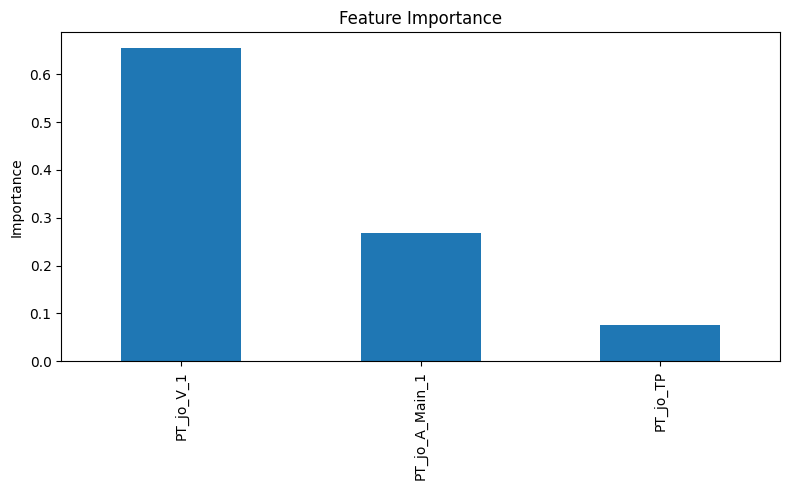

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 모델 생성 및 학습
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# 테스트 데이터에 대해 예측 수행
y_pred = model_rf.predict(X_test)

# 평가 지표 계산 (RMSE, R²)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 특성 중요도 출력 및 시각화 (옵션)
import matplotlib.pyplot as plt

feature_importance = pd.Series(model_rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print("\n📌 Feature Importances:")
print(feature_importance)

feature_importance.plot(kind='bar', title='Feature Importance', figsize=(8,5))
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


### (추가) 온도(PT_jo_TP)가 없을때 성능 비교

In [ ]:
y = df['Thick']
X_base = df[['PT_jo_V_1', 'PT_jo_A_Main_1']]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_base, y, test_size=0.2, random_state=42)

model_a = RandomForestRegressor(random_state=42)
model_a.fit(X_train_a, y_train_a)

y_pred_a = model_a.predict(X_test_a)

rmse_a = np.sqrt(mean_squared_error(y_test_a, y_pred_a))
r2_a = r2_score(y_test_a, y_pred_a)

print("온도 제외 모델\n")
print(f"RMSE : {rmse_a:.4f}")
print(f"R² Score : {r2_a:.4f}")

온도 제외 모델

RMSE : 1.6374
R² Score : 0.5714


## XGBoost

✅ XGBoost RMSE: 1.5503
✅ XGBoost R² Score: 0.6157


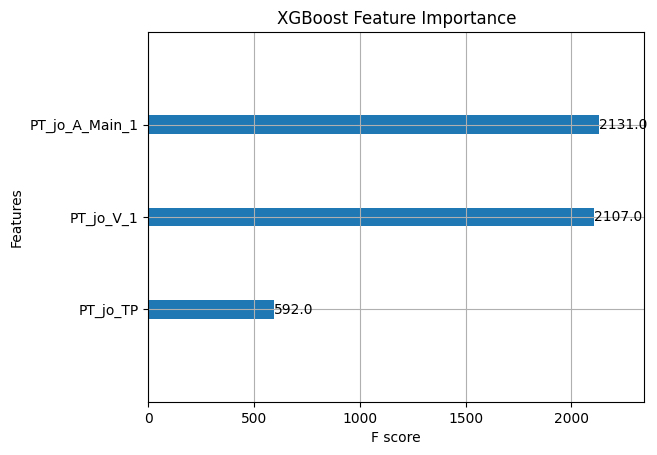

In [ ]:
import xgboost as xgb

# XGBoost 회귀 모델 생성 및 학습
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train, y_train)

# 테스트 데이터에 대해 예측 수행
y_pred = model_xgb.predict(X_test)

# 평가 지표 계산 (RMSE, R²)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ XGBoost RMSE: {rmse:.4f}")
print(f"✅ XGBoost R² Score: {r2:.4f}")

# 특성 중요도 시각화 (옵션)
xgb.plot_importance(model_xgb)
plt.title('XGBoost Feature Importance')
plt.show()

## LightGBM

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.60397
✅ LightGBM RMSE: 1.6040
✅ LightGBM R² Score: 0.5887


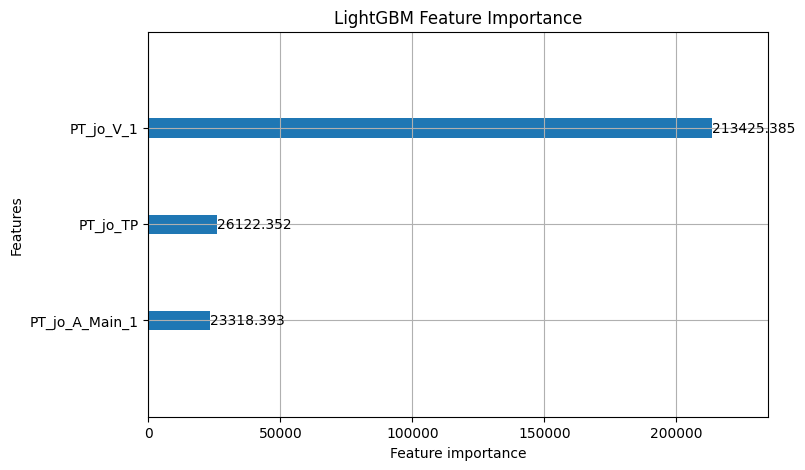

In [ ]:
import lightgbm as lgb

# LightGBM용 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 파라미터 설정 (기본)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed': 42,
    'verbosity': -1
}

# 모델 학습
model_lgbm = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
)

# 예측
y_pred = model_lgbm.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ LightGBM RMSE: {rmse:.4f}")
print(f"✅ LightGBM R² Score: {r2:.4f}")

# 특성 중요도 시각화
lgb.plot_importance(model_lgbm, max_num_features=10, importance_type='gain', figsize=(8,5))
plt.title('LightGBM Feature Importance')
plt.show()

## 딥러닝 (Multi-Layer Perceptron, MLP)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 데이터 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 구성
model_dl = Sequential([
    Input(shape=(3,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# 컴파일
model_dl.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

# 학습
history = model_dl.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, verbose=0)

# 예측 및 평가
y_pred = model_dl.predict(X_test_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ MLP RMSE: {rmse:.4f}")
print(f"✅ MLP R² Score: {r2:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ MLP RMSE: 1.7598
✅ MLP R² Score: 0.5049


- (추가) 딥러닝 고도화

In [ ]:
# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 모델 구성
model_dl_a = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# 컴파일
model_dl_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 학습
history = model_dl_a.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# 예측
y_pred = model_dl_a.predict(X_test).flatten()

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ 개선된 MLP RMSE: {rmse:.4f}")
print(f"✅ 개선된 MLP R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ 개선된 MLP RMSE: 1.6879
✅ 개선된 MLP R² Score: 0.5445


## CatBoost Regressor

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

# CatBoost 모델 생성 및 학습
# CatBoost는 기본적으로 범주형 피처를 자동으로 처리하지만, 현재 피처는 모두 수치형이므로 별도 설정 불필요
model_catboost = CatBoostRegressor(random_state=42, verbose=0) # verbose=0으로 학습 과정 출력 숨김
model_catboost.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred_catboost = model_catboost.predict(X_test)

# 성능 평가
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)

print("✅ CatBoost Regressor 성능")
print(f"RMSE: {rmse_catboost:.4f}")
print(f"R² Score: {r2_catboost:.4f}")

# CatBoost Feature Importance (선택 사항)
print("\n📌 Feature Importances:")
for feature, importance in zip(X_train.columns, model_catboost.get_feature_importance()):
    print(f"{feature}: {importance:.4f}")

✅ CatBoost Regressor 성능
RMSE: 1.5831
R² Score: 0.5993

📌 Feature Importances:
PT_jo_V_1: 62.8099
PT_jo_A_Main_1: 19.3441
PT_jo_TP: 17.8460


## Support Vector Regressor (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler # SVR은 스케일링에 민감

# SVR을 위해 데이터 스케일링
scaler_svr = StandardScaler()
X_train_scaled_svr = scaler_svr.fit_transform(X_train)
X_test_scaled_svr = scaler_svr.transform(X_test)

# SVR 모델 생성 및 학습
# 커널은 'rbf'를 기본으로 사용하며, C와 epsilon 하이퍼파라미터 튜닝 필요 가능
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1) # 기본 하이퍼파라미터
model_svr.fit(X_train_scaled_svr, y_train)

# 테스트 데이터 예측
y_pred_svr = model_svr.predict(X_test_scaled_svr)

# 성능 평가
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print("✅ Support Vector Regressor (SVR) 성능")
print(f"RMSE: {rmse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")

✅ Support Vector Regressor (SVR) 성능
RMSE: 1.7525
R² Score: 0.5090


## K-Nearest Neighbors Regressor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler # KNN도 스케일링에 민감

# 데이터 스케일링
scaler_knn = StandardScaler()
X_train_scaled_knn = scaler_knn.fit_transform(X_train)
X_test_scaled_knn = scaler_knn.transform(X_test)

try:
    X_train_scaled_svr
    X_test_scaled_svr
    X_train_scaled_knn = X_train_scaled_svr
    X_test_scaled_knn = X_test_scaled_svr
except NameError:
     scaler_knn = StandardScaler()
     X_train_scaled_knn = scaler_knn.fit_transform(X_train)
     X_test_scaled_knn = scaler_knn.transform(X_test)


# KNN 모델 생성 및 학습
# n_neighbors 하이퍼파라미터 튜닝 필요 가능
model_knn = KNeighborsRegressor(n_neighbors=5) # 기본 n_neighbors=5
model_knn.fit(X_train_scaled_knn, y_train)

# 테스트 데이터 예측
y_pred_knn = model_knn.predict(X_test_scaled_knn)

# 성능 평가
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print("✅ K-Nearest Neighbors Regressor (KNN) 성능")
print(f"RMSE: {rmse_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")

✅ K-Nearest Neighbors Regressor (KNN) 성능
RMSE: 1.6153
R² Score: 0.5829
